In [1]:
import sys
from pathlib import Path

module_path = Path.cwd().parent
if module_path.as_posix() not in sys.path:
    sys.path.insert(0, Path.cwd().parent.as_posix())

In [2]:
from FreestylePulseOptimization.runners import RuntimeRunner
from FreestylePulseOptimization.runtime.hw_logical2 import (
    HWCI_MatrixSolutionRuntimeLogicalCircuitRunner,
)
import pickle
from typing import Any, Callable, Protocol, Self
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

In [3]:
base_dir = Path.cwd().parent / "final-results"
base_dir = Path.cwd()

In [4]:
files = list(base_dir.glob("**/*.pkl"))
files

[PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA.pkl')]

In [5]:
datum: dict[str, Any] = {}
for file in files:
    datum[file.name] = pickle.loads(file.read_bytes())

In [6]:
data = datum[
    "Nt-10|padding-2|total_shots-1000|distance-1.5|phys_to_logical-[50, 150, 50]|additional_data-{'order': 'd1_u1_d1', 'alignment': 'c_s_c'}.2.pkl"
]

KeyError: "Nt-10|padding-2|total_shots-1000|distance-1.5|phys_to_logical-[50, 150, 50]|additional_data-{'order': 'd1_u1_d1', 'alignment': 'c_s_c'}.2.pkl"

In [7]:
data = datum["DATA.pkl"]

In [8]:
class RelativeDistanceProtocol(Protocol):
    def __call__(self: Self, a: float, *, calc_distance: bool = True) -> float: ...


def rel_dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = a - b if calc_distance else a
        return _f(d) / np.abs(b)

    return _internal


def dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = a - b if calc_distance else a
        return _f(d)

    return _internal


def what_dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = b - a if not calc_distance else a
        return _f(d)

    return _internal

In [9]:
sol = data["solution"]

In [10]:
from typing import ParamSpec

P = ParamSpec("P")


def scale(f: Callable[P, float], scale: float) -> Callable[P, float]:
    def _internal(*args: P.args, **kwargs: P.kwargs) -> float:
        return f(*args, **kwargs) * scale

    return _internal

In [11]:
fr = rel_dist(sol.ci_matrix.ci_ground_state_energy)
f = scale(dist(sol.ci_matrix.ci_ground_state_energy, abs_dist=False), 1e3)
f2 = what_dist(sol.ci_matrix.ci_ground_state_energy, abs_dist=False)

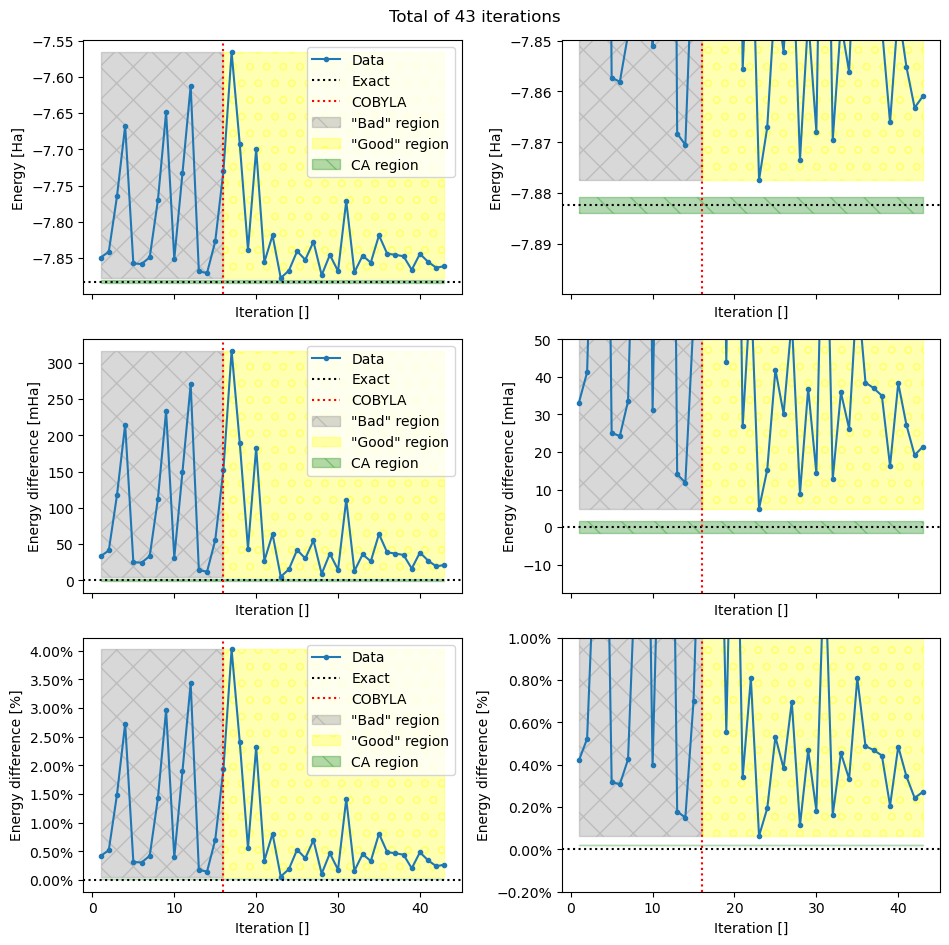

In [16]:
fig, axs = plt.subplot_mosaic(
    [
        ["EE", "zEE"],
        ["EvI", "zEvI"],
        ["dEvI", "zdEvI"],
    ],
    sharex=True,
    figsize=plt.figaspect(1) * (2, 2),
    # [
    #     ['EE', 'EvI', 'dEvI'],
    #     ['EE', 'EvI', 'dEvI'],
    # ]
)

x = np.arange(len(sol.energy_trajectory)) + 1
y = np.array(sol.energy_trajectory)
dy = np.array(sol.energy_error)

Y = np.linspace(y.min(), y.max(), 1_00, endpoint=True)

CA = 0.0016

exact = sol.ci_matrix.ci_ground_state_energy

fig.suptitle(f"Total of {len(x)} iterations")

for ax_name, c_f, ticks, ylbl, top_val in zip(
    ("EE", "EvI", "dEvI"),
    (f2, f, fr),
    (None, None, ticker.PercentFormatter(1.0)),
    ("Energy [Ha]", "Energy difference [mHa]", "Energy difference [%]"),
    (-7.85, 50, 0.01),
):
    # axs[ax_name].errorbar(x, c_f(y), yerr=c_f(dy), marker='.', capsize=2.5)
    for prefix in ("", "z"):
        ax = axs[f"{prefix}{ax_name}"]
        ax.plot(x, c_f(y), marker=".", label="Data")
        if ticks is not None:
            ax.yaxis.set_major_formatter(ticks)

        ax.axhline(
            c_f(sol.ci_matrix.ci_ground_state_energy), color="k", ls=":", label="Exact"
        )
        ax.axvline(
            cobyla := len(sol.parameter_names) * 2, color="r", ls=":", label="COBYLA"
        )
        ax.fill_betweenx(
            c_f(Y),
            x.min(),
            cobyla,
            alpha=0.3,
            color="gray",
            hatch="x",
            label='"Bad" region',
        )
        ax.fill_betweenx(
            c_f(Y),
            cobyla,
            x.max(),
            alpha=0.3,
            color="yellow",
            hatch="o",
            label='"Good" region',
        )
        ax.fill_between(
            x,
            c_f(CA, calc_distance=False),
            c_f(-CA, calc_distance=False),
            alpha=0.3,
            color="g",
            hatch="\\",
            label="CA region",
        )

        ax.set(xlabel="Iteration []", ylabel=ylbl)

        if prefix == "z":
            ax.set_ylim(
                top=top_val,
            )
        else:
            ax.legend()


# ax.set_ylim(0, .005)

fig.tight_layout()

# fig.savefig('../../../LiH-last-run.png', dpi=600, bbox_inches='tight')

plt.show()
plt.close(fig)

In [43]:
help(ax.legend)

Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._axes.Axes instance
    Place a legend on the Axes.

    Call signatures::

        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)

    The call signatures correspond to the following different ways to use
    this method:

    **1. Automatic detection of elements to be shown in the legend**

    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.

    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::

        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()

    or::

        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()

    .. note::
        Specific artists can be excluded from the autom

In [64]:
f"{f(y[best_ind]):.2f}"

'4.96'

In [71]:
ax.transAxes

In [168]:
f(y)[22]

4.956907408234734

In [25]:
from FreestylePulseOptimization.runtime.hw_logical2 import (
    convert_ordered_channels_to_schedule,
    convert_parameters_to_channels_ordered,
)

In [26]:
sol.additional_data["padding"]

<PaddingType.LEFT: 2>

In [27]:
sol.phys_to_logical

[50, 150, 50]

In [28]:
sol.dt

5e-10

In [29]:
from qiskit_dynamics.pulse import InstructionToSignals

In [30]:
from cycler import cycler
from typing import Optional
from qiskit_dynamics import Signal
from collections.abc import Sequence
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from numpy.typing import NDArray


def plot_signals(
    signals: Sequence[Signal],
    duration: float,
    *,
    colormap: str = "tab20c",
    num_points: int = 1_00,
    max_y: Optional[float] = None,
    min_y: Optional[float] = None,
    remove_channels: Optional[Sequence[str]] = None,
    fig: Optional[Figure] = None,
    axs: Optional[NDArray[Axes]] = None,
) -> tuple[Figure, NDArray[Axes]]:
    signal_count = np.array(
        [
            remove_channels is None or signal.name not in remove_channels
            for signal in signals
        ],
        dtype=bool,
    )
    N = sum(signal_count)
    rel_signals = np.array(signals)[np.where(signal_count)[0]]

    if fig is None and axs is None:
        fig, axs = plt.subplots(nrows=N, sharex=True, gridspec_kw=dict(hspace=0))

    colors = plt.get_cmap(colormap, N)(np.linspace(0.0, 1.0, N))
    for i, s in enumerate(rel_signals):
        if remove_channels is not None and s.name in remove_channels:
            continue
        axs[i].axhline(0, color="k", ls="dotted")
        axs[i].annotate(
            text=f"{s.name}",
            xy=(-0.1, 0.5),
            xytext=(-1.5, 0),
            xycoords=axs[i].transAxes,
            textcoords="offset fontsize",
        )
        cyc = cycler(color=[colors[i]]) * cycler(linestyle=["-", ":"])
        axs[i].set_prop_cycle(cyc)
        s.draw(0, duration, num_points, "envelope", axis=axs[i])
        # axs[i].set_ylim(-.15, .15,)
        axs[i].set_ylim(
            bottom=min_y,
            top=max_y,
        )
        legend = axs[i].get_legend()
        if legend is not None:
            legend.remove()

    axs[-1].set(xlabel="t [ns]")
    fig.tight_layout()
    return fig, axs

In [ ]:
InstructionToSignals

In [31]:
s = convert_ordered_channels_to_schedule(
    convert_parameters_to_channels_ordered(
        sol.qubit_spec,
        [("d", 1), ("u", 1), ("d", 1)],
        ["c", "s", "c"],
        [50, 150, 50],
        sol.parameter_names,
        sol.additional_data["padding"],
        sol.additional_data["timing_constraints"],
    )(sol.parameters_trajectory[22])
)

In [32]:
from FreestylePulseOptimization import get_device_parameters, generate_solver

In [33]:
from FreestylePulseOptimization.runners import RuntimeRunner

In [34]:
runner = RuntimeRunner(
    channel="ibm_quantum", instance="ibm-q/open/main", backend_name="ibm_brisbane"
)

In [35]:
sol.additional_data["backend_name"]

'ibm_brisbane'

In [36]:
qubits, dt = get_device_parameters(runner.backend, (0, 1, 2))

In [37]:
solver, real2sim, connection_map, signal_maker = generate_solver(qubits, dt, True)

In [41]:
s.duration * dt

208.0

/tmp/ipykernel_9259/1858617493.py:24: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  data, = ax.plot('x', 'y', data=fig_data, marker=".", label='Data')


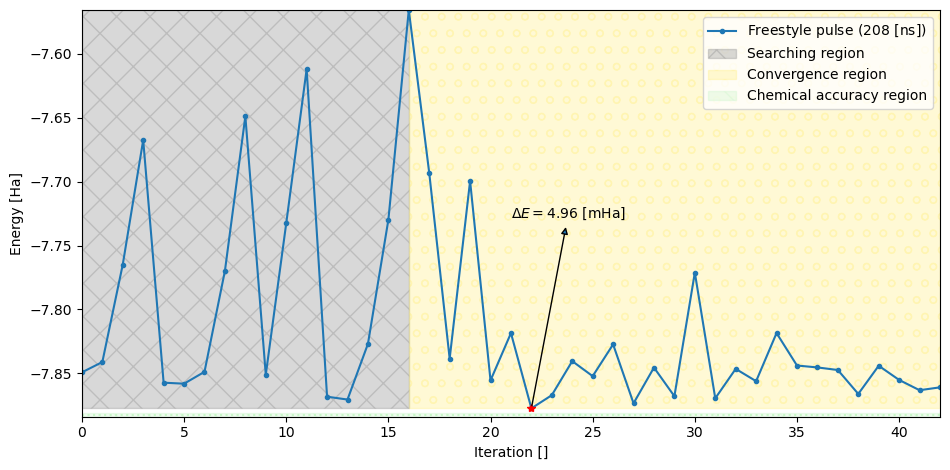

In [103]:
fig_data = {
    "x": np.arange(len(y)),
    "y": y,
    "exact": exact,
    "CA": CA,
    "cobyla": cobyla,
}

fig, ax = plt.subplots(figsize=plt.figaspect(1) * (2, 1))

best_ind = y.argmin()

labels = [
    f"Freestyle pulse (${s.duration*dt:.0f}~[\\mathrm{{ns}}]$)",
    "Searching region",
    "Convergence region",
    "Chemical accuracy region",
    "__nolegend__",
    f"$\\Delta E={f(y[best_ind]):.2f}~[\\mathrm{{mHa}}]$",
]

x = np.arange(len(y))

(data,) = ax.plot("x", "y", data=fig_data, marker=".", label="Data")
exact_line = ax.axhline(fig_data["exact"], color="#c7f6c7", ls=":", label="Exact")
# ax.axvline(cobyla := len(sol.parameter_names) * 2, color="r", ls=":", label='COBYLA')
search_region = ax.fill_betweenx(
    Y,
    x.min(),
    fig_data["cobyla"],
    alpha=0.3,
    color="gray",
    hatch="x",
    label='"Bad" region',
)
convergance_region = ax.fill_betweenx(
    Y,
    fig_data["cobyla"],
    x.max(),
    alpha=0.3,
    color="#ffee75",
    hatch="o",
    label='"Good" region',
)
ca_region = ax.fill_between(
    x,
    fig_data["exact"] - fig_data["CA"],
    fig_data["exact"] + fig_data["CA"],
    alpha=0.3,
    color="#c7f6c7",
    hatch="\\",
    label="CA region",
)
ax.set(xlabel="Iteration []", ylabel="Energy [Ha]")

best_x = fig_data["x"][best_ind]
best_y = fig_data["y"][best_ind]

(best_line,) = ax.plot(best_x, best_y, marker="*", color="r", ls="")

ax.annotate(
    labels[-1],
    xy=(best_x, best_y),
    xycoords=ax.transData,
    xytext=(0.5, 0.5),
    textcoords=ax.transAxes,
    arrowprops=dict(
        arrowstyle="<|-",
    ),
    va="center",
    ha="left",
)
handles = [
    data,
    search_region,
    convergance_region,
    ca_region,
    exact_line,
    best_line,
]

labels[-1] = "_"

leg_handles = [
    handle for handle, label in zip(handles, labels) if not label.startswith("_")
]
leg_labels = [label for label in labels if not label.startswith("_")]

ax.legend(leg_handles, leg_labels)


ax.set_xlim(x.min(), x.max())

ax.set_ylim(min([exact - CA, y.min()]), y.max())

fig.tight_layout()

file_name = Path.cwd() / "LiH_d=1.5_Nq=3.png"
fig.savefig(file_name, dpi=600, bbox_inches="tight")
file_name.with_stem("pkl").write_bytes(pickle.dumps(fig_data))

plt.show()
plt.close(fig)

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='t [ns]'>],
       dtype=object))

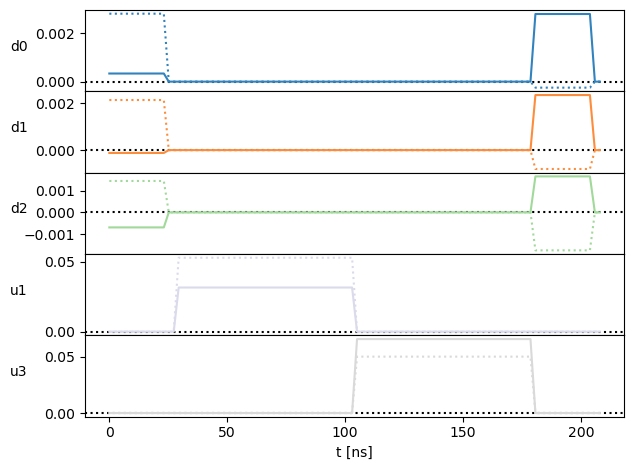

In [38]:
plot_signals(signal_maker(s), s.duration * dt)

In [32]:
sol

HWCI_MatrixSolutionRuntimeLogicalCircuitRunner(ci_matrix=CI_Matrix(mol_name='LiH', distance=1.5, n_dim=8, nuclear_repulsion_energy=1.0583544213400002, ci_ground_state_energy=-7.8823622868109116, matrix=array([[-8.92171204e+00,  1.22953309e-01,  3.34934448e-02,
         3.34934448e-02,  2.33437370e-09,  2.33437370e-09,
         1.21386268e-02,  2.39870437e-02],
       [ 1.22953309e-01, -7.81887101e+00, -2.48202369e-02,
        -2.48202369e-02, -3.10577639e-02, -3.10577639e-02,
         2.63029784e-02,  1.94732102e-02],
       [ 3.34934448e-02, -2.48202369e-02, -8.17786686e+00,
         2.63029784e-02, -8.44455007e-03,  1.41706666e-01,
        -1.04426038e-01,  1.38655674e-02],
       [ 3.34934448e-02, -2.48202369e-02,  2.63029784e-02,
        -8.17786686e+00,  1.41706666e-01, -8.44455007e-03,
        -1.04426038e-01,  1.38655674e-02],
       [ 2.33437370e-09, -3.10577639e-02, -8.44455007e-03,
         1.41706666e-01, -8.76364400e+00,  1.21386268e-02,
         5.30971768e-02,  1.92101279